# ***Multi-Output Coin Classification Model***
# Overview
This notebook develops a multi-output classifier as the second stage in a coin recognition pipeline. The classifier is trained on segmented coin images produced by a preceding segmentation model and is responsible for three distinct classification tasks:


1.   UK Classification – Determines whether a coin belongs to the UK currency system.

2.  Denomination Prediction – Identifies the specific denomination, but only for UK coins.

3.  Side Classification – Predicts whether the visible side of the coin is Heads or Tails.



# Dataset
The training data consists of images from two datasets:

Dataset 1 – Higher resolution images with minimal occlusion, providing clearer features for classification.

Dataset 2 – Lower resolution images with more occluded coins, increasing the challenge of classification.

Before training, an extensive dataset quality analysis was conducted, assessing the shape, color, and overall quality of each coin to better understand dataset characteristics and potential biases.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## *Libraries Imports*

In [2]:
# basic libraries to handle files, dataframes,numbers, and visualizations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image  #image processing


In [3]:
# scikit-learn tools for splitting data and evaluating models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight  #  for imbalanced datasets

In [4]:
# PyTorch core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [5]:

# torchvision for image transforms and pretrained models
import torchvision.transforms as transforms
import torchvision.models as models


# Configuration

In [6]:
IMG_DIR = "/content/drive/MyDrive/Hexcel_Company_Project/Classifier_Training_Data_Cropped_coins"
CSV_PATH = "/content/drive/MyDrive/Hexcel_Company_Project/Classifier_coin_labels_.csv"


In [7]:
# Image/model training settings
IMAGE_SIZE = 224  # efficientnet expects 224x224
BATCH_SIZE = 32
EPOCHS = 20

# Loading and Cleaning the Data

The dataset is loaded from a CSV file. Column names are stripped of extra whitespace to ensure consistency. Categorical text values such as "uk" and "side" are mapped to numerical labels for downstream processing.Each denomination is then encoded into a unique integer for use in classification model.

In [8]:
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

#Convert labeles in the csv 'yes'/'no' in the 'uk' column to binary (1/0)
df['uk_label'] = df['uk'].map({'yes': 1, 'no': 0})

# Same idea here, turn 'heads'/'tails' into 1s and 0s
df['side_label'] = df['side'].map({'heads': 1, 'tails': 0})
# Unkown Label is used for the denomination of the NON-UK coins
df['denomination'] = df['denomination'].fillna('Unknown')

In [9]:
# all the unique denomination classes, sorted alphabetically and
# map each denomination to a unique integer label
denom_classes = sorted(df['denomination'].dropna().unique().tolist())
df['denom_label'] = df['denomination'].map({cls: i for i, cls in enumerate(denom_classes)})

# Data Analysis

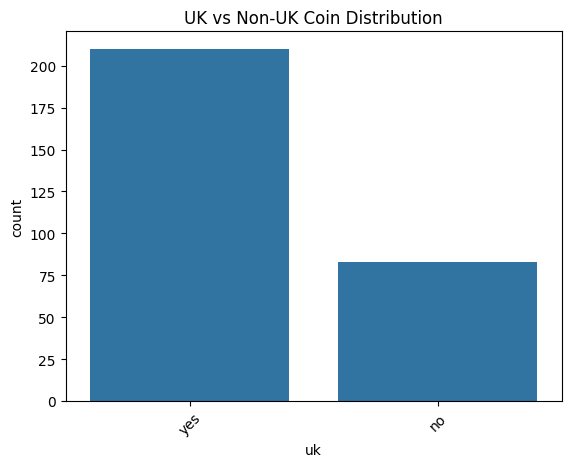

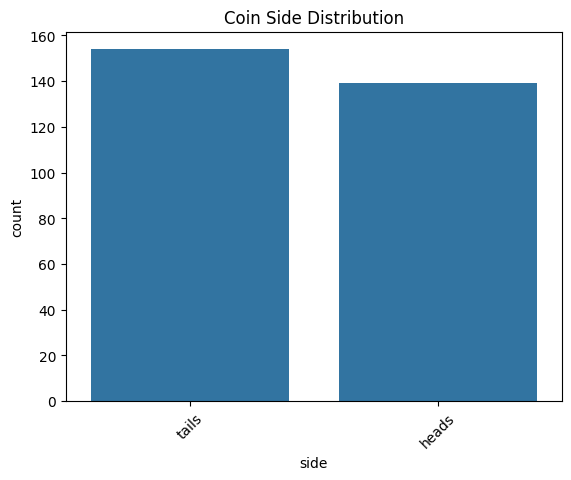

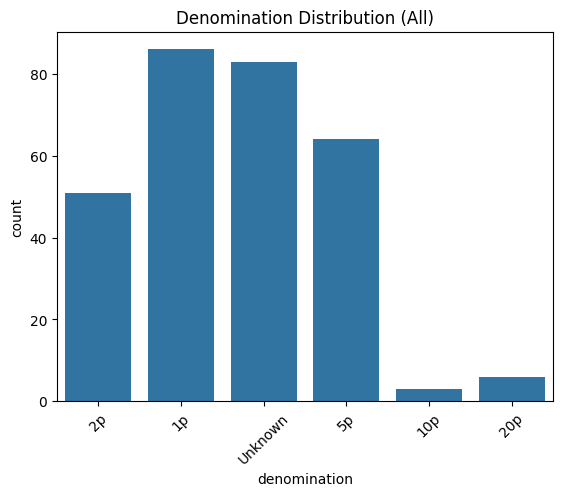

In [10]:
# helper function for quick bar plots of any column
def plot_class_dist(column, title):
    sns.countplot(data=df, x=column)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot the main categorical features
plot_class_dist('uk', 'UK vs Non-UK Coin Distribution')
plot_class_dist('side', 'Coin Side Distribution')
plot_class_dist('denomination', 'Denomination Distribution (All)')

In [11]:
# Printig raw counts just for clarity
print("UK vs Non-UK:\n", df['uk'].value_counts(), "\n")
print("Denomination:\n", df['denomination'].value_counts(), "\n")
print("Heads vs Tails:\n", df['side'].value_counts(), "\n")

UK vs Non-UK:
 uk
yes    210
no      83
Name: count, dtype: int64 

Denomination:
 denomination
1p         86
Unknown    83
5p         64
2p         51
20p         6
10p         3
Name: count, dtype: int64 

Heads vs Tails:
 side
tails    154
heads    139
Name: count, dtype: int64 



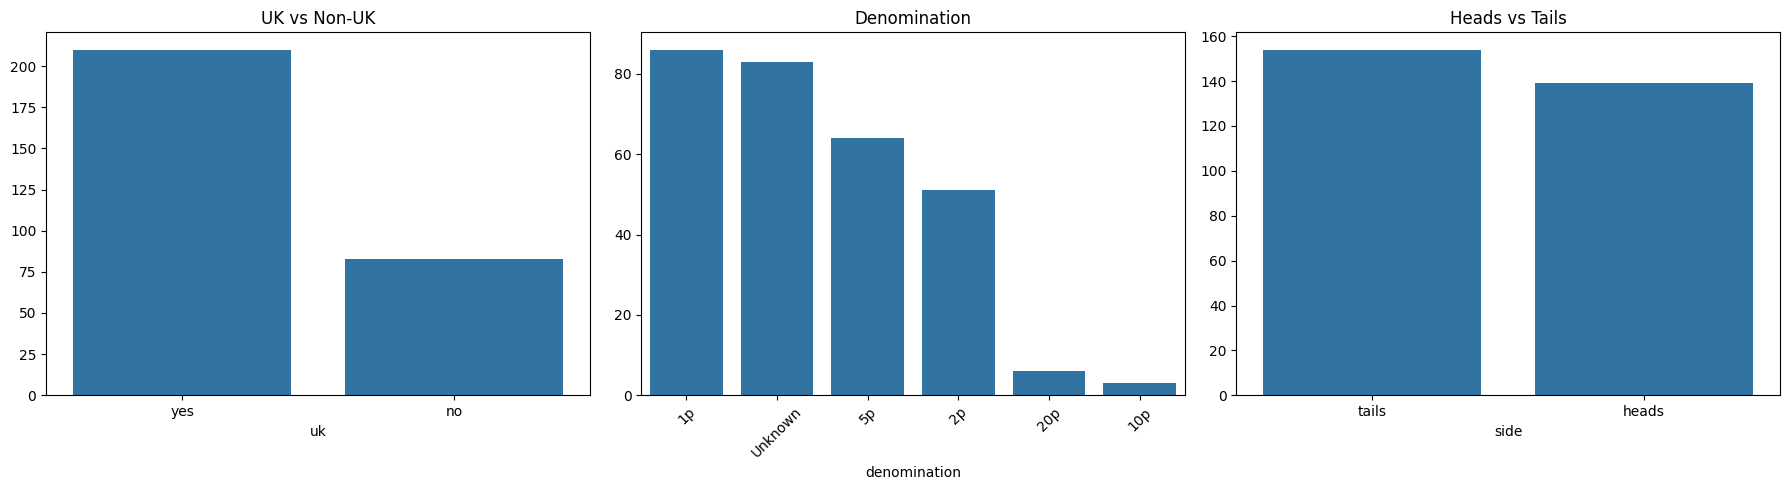

In [12]:
# Plot all three distributions side-by-side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=df['uk'].value_counts().index, y=df['uk'].value_counts().values, ax=axs[0])
sns.barplot(x=df['denomination'].value_counts().index, y=df['denomination'].value_counts().values, ax=axs[1])
sns.barplot(x=df['side'].value_counts().index, y=df['side'].value_counts().values, ax=axs[2])
axs[1].tick_params(axis='x', rotation=45)
axs[0].set_title("UK vs Non-UK"), axs[1].set_title("Denomination"), axs[2].set_title("Heads vs Tails")

plt.tight_layout()
plt.show()

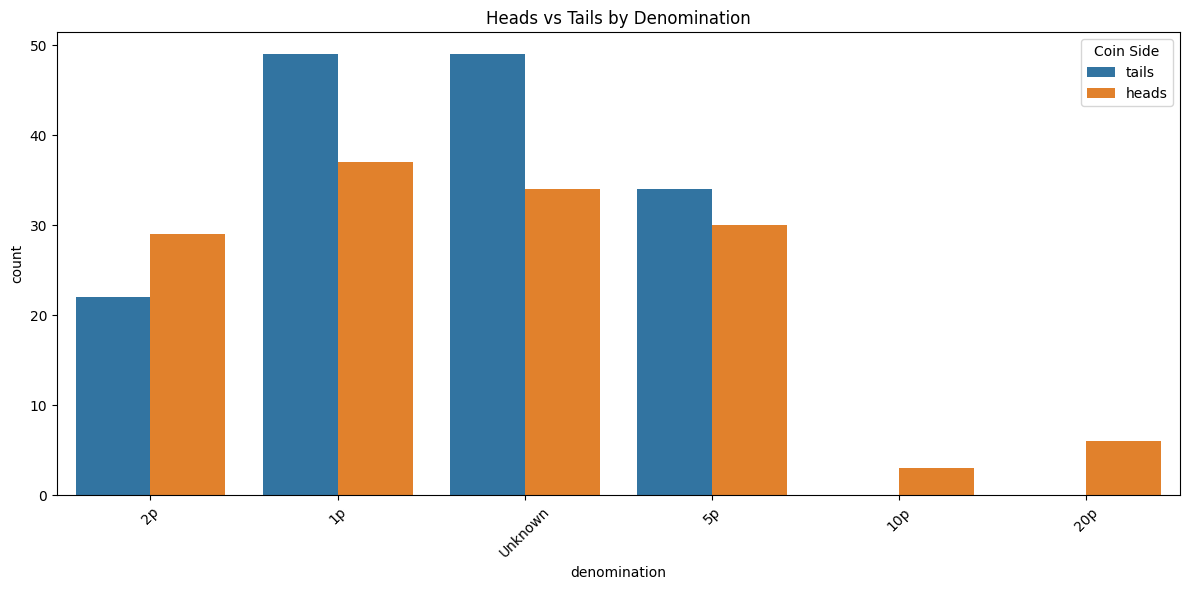

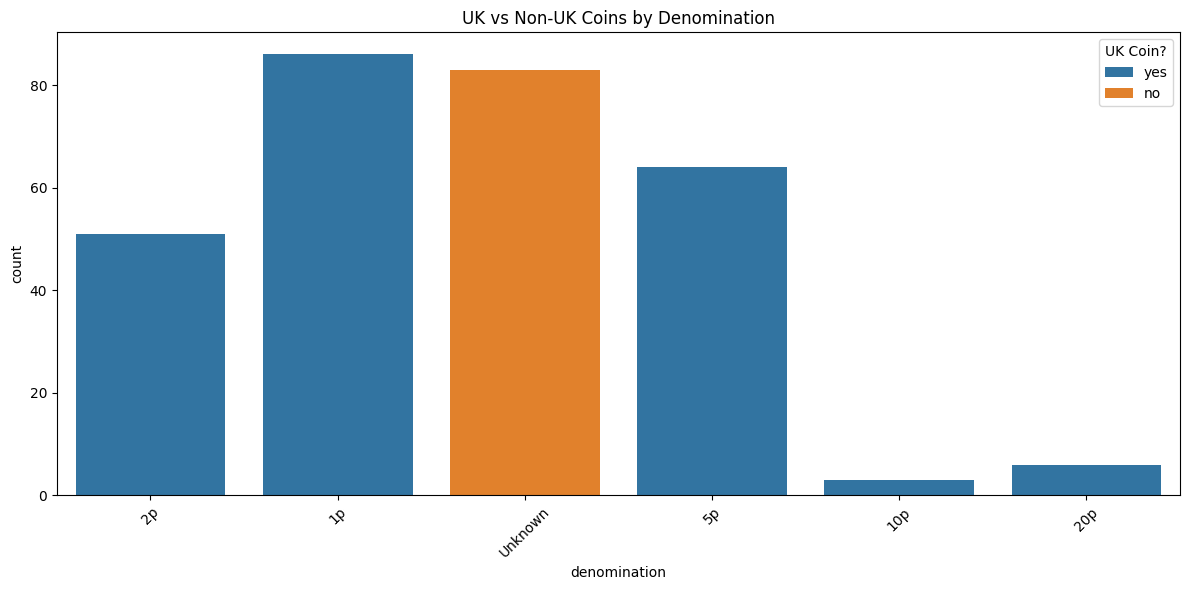

In [13]:
# Heads/tails split within each denomination
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='denomination', hue='side')
plt.title("Heads vs Tails by Denomination")
plt.xticks(rotation=45)
plt.legend(title='Coin Side')
plt.tight_layout()
plt.show()

# UK vs Non-UK per denomination
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='denomination', hue='uk')
plt.title("UK vs Non-UK Coins by Denomination")
plt.xticks(rotation=45)
plt.legend(title='UK Coin?')
plt.tight_layout()
plt.show()


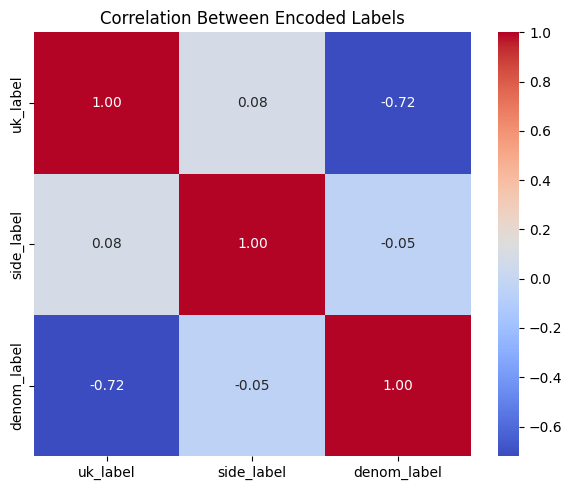

In [14]:
# Correlation heatmap between the encoded labels
plt.figure(figsize=(6,5))
corr = df[['uk_label', 'side_label', 'denom_label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Encoded Labels")
plt.tight_layout()
plt.show()


# Summary of Exploratory Data Analysis:

The dataset contains labeled images of coins, annotated with features such as country of origin (UK vs. non-UK), coin side (heads or tails), and denomination. The following key observations were made during exploration:

-  Country Distribution: The dataset is imbalanced, with a higher proportion of UK coins compared to non-UK coins. This may require class balancing or weighting during model training to avoid biased predictions.

-  Denomination and Origin: Coins from non-UK origins are intentionally assigned the denomination 'Unknown' to distinguish them from standard UK denominations. This helps isolate domain-specific patterns and can be used as a feature for classification or filtering.

-  Side Distribution: The overall distribution between heads and tails is relatively balanced across most denominations, though certain categories for example ( 10p, 20p) are underrepresented.

-  Class Imbalance in Denominations: While common denominations such as 1p, 5p, and Unknown are well-represented, others have limited samples. These imbalances may negatively affect model generalization if not addressed.

-  Feature Correlation: Correlation analysis between encoded labels showed minimal redundancy, indicating that uk_label, side_label, and denom_label provide distinct signals and can be used concurrently in modeling.

Overall, the dataset shows moderate class imbalance but provides sufficient structure for supervised learning tasks. Proper handling of low-frequency classes and origin-specific features will be important to ensure robust model performance.

# Further Analysis

<ipython-input-17-b783cb8130de>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='quality', order=sorted(df['quality'].unique()), palette='pastel')


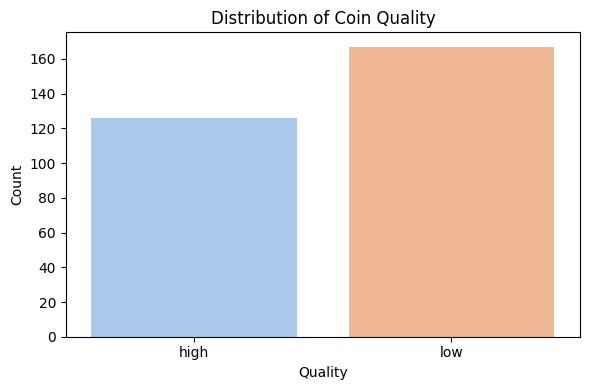

<ipython-input-17-b783cb8130de>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='shape', palette='Set2')


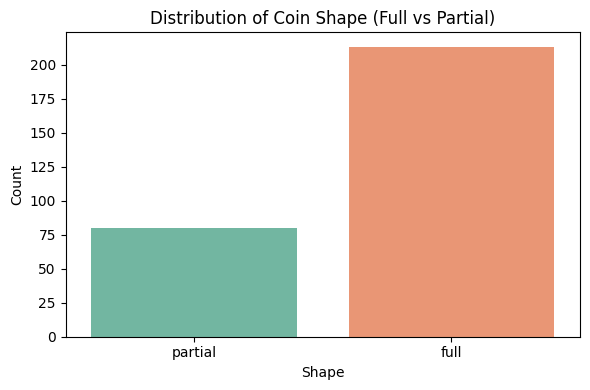

<ipython-input-17-b783cb8130de>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Color', palette='Set3', order=sorted(df['Color'].unique()))


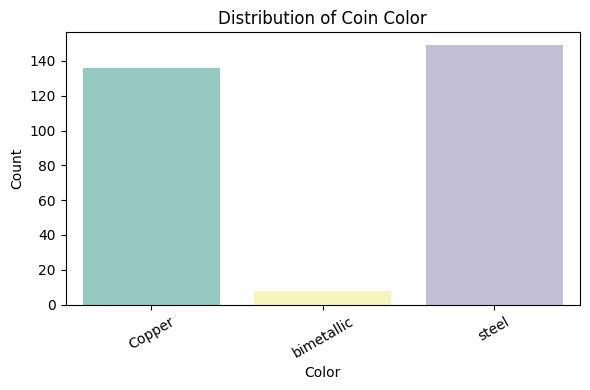

In [17]:
# Quality Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='quality', order=sorted(df['quality'].unique()), palette='pastel')
plt.title('Distribution of Coin Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Shape Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='shape', palette='Set2')
plt.title('Distribution of Coin Shape (Full vs Partial)')
plt.xlabel('Shape')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Color Distribution (copper,steel/silver, bimetallic/gold)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Color', palette='Set3', order=sorted(df['Color'].unique()))
plt.title('Distribution of Coin Color')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Coin Quality, Shape, and Color

These plots show the distribution of three physical attributes in the dataset:

-  Quality: There are more low-quality coins than high-quality ones. This gives an idea of the overall condition of the images in the dataset as it was constructed from both datasets folders given.

-  Shape: Most coins are fully visible (full), while a smaller portion are partial coins. Partial coins have been extracted from overlapping areas.

-  Color: The most common colors are copper and steel. A few coins are labeled as bimetallic, which are less frequent in the dataset and a non-uk coins.

These attributes are useful for understanding the variety and condition of the coin images but are not used directly for training in this case.

# Handling Class Imbalance

Before training, it's important to address class imbalance — particularly in the denomination labels. This function performs basic upsampling to ensure that each denomination class has roughly the same number of examples. Balancing improves model fairness and prevents bias toward overrepresented classes.

In [10]:
def balance_classes(df, target=100):
    print("Original class distribution:")
    print(df['denomination'].value_counts())

    balanced = [df]
    for label in df['denomination'].unique():
        subset = df[df['denomination'] == label]
        count = len(subset)
        repeat = max((target // count) - 1, 0)
        if repeat > 0:
            print(f"Upsampling denomination '{label}' by {repeat}x")
            balanced += [subset] * repeat

    df_balanced = pd.concat(balanced).sample(frac=1, random_state=42).reset_index(drop=True)

    print("Balanced class distribution:")
    print(df_balanced['denomination'].value_counts())
    return df_balanced

# this will apply balancing to the original dataframe
df_augmented = balance_classes(df)


Original class distribution:
denomination
1p         86
Unknown    83
5p         64
2p         51
20p         6
10p         3
Name: count, dtype: int64
Upsampling denomination '10p' by 32x
Upsampling denomination '20p' by 15x
Balanced class distribution:
denomination
10p        99
20p        96
1p         86
Unknown    83
5p         64
2p         51
Name: count, dtype: int64


# Preparing the Dataset Class

A custom Dataset class is created to load images and corresponding labels. This class will be used by PyTorch DataLoaders during training and validation. It handles image loading, optional transforms, and returns labels for multi-task classification (uk, side, and denomination).

In [11]:
class CoinDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            raise e

        if self.transform:
            image = self.transform(image)

        labels = {
            'uk': torch.tensor(row['uk_label'], dtype=torch.long),
            'side': torch.tensor(row['side_label'], dtype=torch.long),
            'denomination': torch.tensor(row['denom_label'], dtype=torch.long),
        }

        return image, labels


# Image Augmentation and Normalization

Image transforms are applied to improve generalization and prepare data for training.the training set uses augmentation such as flips, rotation, color jitter, while the validation set is only resized and normalized. All images are converted to tensors and normalized to a consistent scale.



In [12]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize from [0,1] to [-1,1]
])


In [13]:
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Splitting the Data

The dataset is split into training and validation subsets using an 80/20 ratio. These subsets are then wrapped into PyTorch DataLoader objects, which efficiently feed data to the model in mini-batches during training.

In [14]:
train_df, val_df = train_test_split(df_augmented, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 383
Validation samples: 96


In [15]:

train_loader = DataLoader(
    CoinDataset(train_df, IMG_DIR, transform=train_transform),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CoinDataset(val_df, IMG_DIR, transform=val_transform),
    batch_size=BATCH_SIZE
)


# Building the Model

The model is based on a pretrained EfficientNet-B0 backbone. The final classification layer is replaced with three separate heads to handle the three prediction tasks: identifying if the coin is UK or not, detecting which side is visible, and predicting the denomination. This setup enables multi-task learning from a shared feature extractor.

Hence the model doing 3 tasks :

- If the coin is from the UK -> (Binary classification)

- Which side is visible -> ( binary classification)

- Denomination prediction -> (Multi-class classification)


In [52]:
!wget https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth -P /root/.cache/torch/hub/checkpoints/


--2025-04-02 00:26:59--  https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.38, 18.65.3.37, 18.65.3.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.38|:443... connected.
ERROR: cannot verify download.pytorch.org's certificate, issued by ‘CN=Amazon RSA 2048 M03,O=Amazon,C=US’:
  Issued certificate has expired.
To connect to download.pytorch.org insecurely, use `--no-check-certificate'.


In [43]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [16]:
import timm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


In [17]:
class CoinClassifier(nn.Module):
    def __init__(self, num_denom_classes):
        super().__init__()
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.feature_dim = base.classifier[1].in_features
        base.classifier = nn.Identity()
        self.backbone = base

        # Multi-task heads
        self.uk_head = nn.Linear(self.feature_dim, 2)
        self.side_head = nn.Linear(self.feature_dim, 2)
        self.denom_head = nn.Linear(self.feature_dim, num_denom_classes)

    def forward(self, x):
        features = self.backbone(x)
        return {
            'uk': self.uk_head(features),
            'side': self.side_head(features),
            'denomination': self.denom_head(features)
        }


# Setting Up Training Components

Finally, the training setup is completed. The model is moved to GPU (if available), and appropriate loss functions are defined for each task. Class weights are calculated to handle label imbalance. An Adam optimizer is initialized to update the model parameters during training.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [19]:
#  weights for imblanced classes
uk_weights = compute_class_weight('balanced', classes=np.array([0,1]), y=train_df['uk_label'])
denom_weights = compute_class_weight('balanced', classes=np.unique(train_df['denom_label']), y=train_df['denom_label'])

print(f"UK class weights: {uk_weights}")
print(f"Denomination class weights: {denom_weights}")


UK class weights: [2.73571429 0.61182109]
Denomination class weights: [0.75098039 0.92512077 0.87442922 1.59583333 1.38768116 0.91190476]


In [20]:
# Defning the loss functions
loss_uk = nn.CrossEntropyLoss(weight=torch.tensor(uk_weights, dtype=torch.float).to(device))
loss_side = nn.CrossEntropyLoss()  # no class weights are needed
loss_denom = nn.CrossEntropyLoss(weight=torch.tensor(denom_weights, dtype=torch.float).to(device))


In [23]:
# Initialize model and optimizer
model = CoinClassifier(num_denom_classes=train_df['denom_label'].nunique()).to(device)
#model = CoinClassifier(num_denom_classes=len(denom_classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(model)
print("done.")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 29.4MB/s]


CoinClassifier(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

# Training the Model

The training loop runs for a defined number of epochs and optimizes the multi-head model for the three tasks

Also Losses are tracked separately for each task to better understand how the model is learning.

In [25]:
# Lists to keep track of how losses evolve over epochs
train_losses = []
uk_losses = []
side_losses = []
denom_losses = []


In [ ]:
# Start training


for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0
    loss_uk_total = 0.0
    loss_side_total = 0.0
    loss_denom_total = 0.0

    # looping over batches
    for images, labels in train_loader:
        images = images.to(device)
        uk = labels['uk'].to(device)
        side = labels['side'].to(device)
        denom = labels['denomination'].to(device)


        optimizer.zero_grad() # reset gradients

        outputs = model(images) #forward pass

        # compute losses for UK and Side pred.
        loss_uk_val = loss_uk(outputs['uk'], uk)
        loss_side_val = loss_side(outputs['side'], side)
        loss = loss_uk_val + loss_side_val

        # only compute denomination loss for UK coins
        uk_mask = uk == 1
        if uk_mask.any():
            denom_preds = outputs['denomination'][uk_mask]
            denom_targets = denom[uk_mask]
            loss_denom_val = loss_denom(denom_preds, denom_targets)
            loss += loss_denom_val
            loss_denom_total += loss_denom_val.item()

        # Boackprop and update weights
        loss.backward()
        optimizer.step()

        # Track losses for the batch
        running_loss += loss.item()
        loss_uk_total += loss_uk_val.item()
        loss_side_total += loss_side_val.item()

    # calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_uk = loss_uk_total / len(train_loader)
    epoch_side = loss_side_total / len(train_loader)
    epoch_denom = loss_denom_total / len(train_loader)

    # later for plotting
    train_losses.append(epoch_loss)
    uk_losses.append(epoch_uk)
    side_losses.append(epoch_side)
    denom_losses.append(epoch_denom)

    # Console summary for tracking
    print(f"Epoch {epoch+1}/{EPOCHS} | Total Loss: {epoch_loss:.4f} | UK: {epoch_uk:.4f} | Side: {epoch_side:.4f} | Denom: {epoch_denom:.4f}")



Epoch 1/20 | Total Loss: 2.8050 | UK: 0.6531 | Side: 0.6439 | Denom: 1.5080
Epoch 2/20 | Total Loss: 1.9306 | UK: 0.4716 | Side: 0.4509 | Denom: 1.0082
Epoch 3/20 | Total Loss: 1.4824 | UK: 0.3721 | Side: 0.3628 | Denom: 0.7475
Epoch 4/20 | Total Loss: 1.1268 | UK: 0.2889 | Side: 0.3061 | Denom: 0.5317
Epoch 5/20 | Total Loss: 0.8499 | UK: 0.2225 | Side: 0.2341 | Denom: 0.3932
Epoch 6/20 | Total Loss: 0.6435 | UK: 0.1791 | Side: 0.1996 | Denom: 0.2649
Epoch 7/20 | Total Loss: 0.5200 | UK: 0.1461 | Side: 0.1520 | Denom: 0.2219
Epoch 8/20 | Total Loss: 0.3801 | UK: 0.1087 | Side: 0.1240 | Denom: 0.1475
Epoch 9/20 | Total Loss: 0.2904 | UK: 0.0915 | Side: 0.0900 | Denom: 0.1088
Epoch 10/20 | Total Loss: 0.2473 | UK: 0.0821 | Side: 0.0760 | Denom: 0.0893
Epoch 11/20 | Total Loss: 0.1906 | UK: 0.0635 | Side: 0.0590 | Denom: 0.0682
Epoch 12/20 | Total Loss: 0.1522 | UK: 0.0442 | Side: 0.0602 | Denom: 0.0478
Epoch 13/20 | Total Loss: 0.1237 | UK: 0.0367 | Side: 0.0439 | Denom: 0.0432
Epoch 14

# Visualizing Training Losses


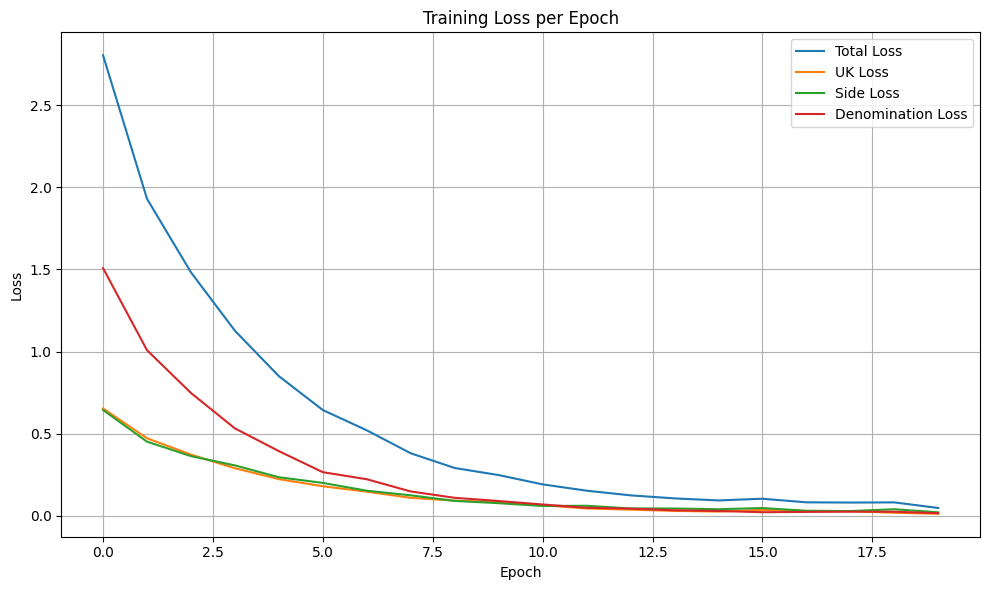

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Total Loss')
plt.plot(uk_losses, label='UK Loss')
plt.plot(side_losses, label='Side Loss')
plt.plot(denom_losses, label='Denomination Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/Hexcel_Company_Project/Classifier_model/coin_classifier_final.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/Hexcel_Company_Project/Classifier_model/coin_classifier_final.pth


# Validation & Metrics


--- Classification Report: UK ---
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.95      0.98        83

    accuracy                           0.96        96
   macro avg       0.88      0.98      0.92        96
weighted avg       0.97      0.96      0.96        96


--- Classification Report: SIDE ---
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        35
           1       0.94      0.97      0.95        61

    accuracy                           0.94        96
   macro avg       0.94      0.93      0.93        96
weighted avg       0.94      0.94      0.94        96


--- Classification Report: DENOMINATION (UK Only) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.94      0.94        17
           2       1.00      1.00      1.00        23
  

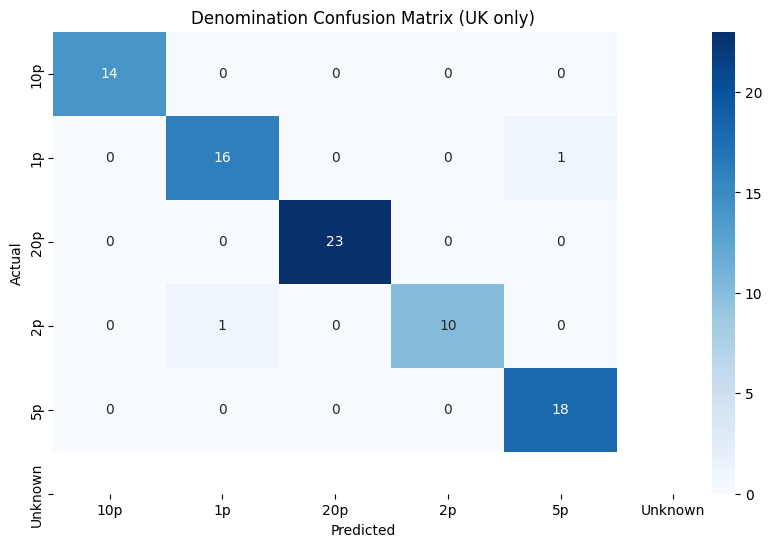

In [ ]:
model.eval()
y_true, y_pred = {'uk': [], 'side': [], 'denomination': []}, {'uk': [], 'side': [], 'denomination': []}

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)

        for task in ['uk', 'side']:
            y_true[task].extend(labels[task].numpy())
            y_pred[task].extend(torch.argmax(outputs[task], dim=1).cpu().numpy())

        uk_mask = labels['uk'] == 1
        if uk_mask.any():
            y_true['denomination'].extend(labels['denomination'][uk_mask].numpy())
            y_pred['denomination'].extend(torch.argmax(outputs['denomination'][uk_mask], dim=1).cpu().numpy())

# reports
for task in ['uk', 'side']:
    print(f"\n--- Classification Report: {task.upper()} ---")
    print(classification_report(y_true[task], y_pred[task]))

print("\n--- Classification Report: DENOMINATION (UK Only) ---")
print(classification_report(y_true['denomination'], y_pred['denomination']))

# Confusion Matrix
cm = confusion_matrix(y_true['denomination'], y_pred['denomination'])
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=denom_classes, yticklabels=denom_classes)
plt.title("Denomination Confusion Matrix (UK only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation Summary – Classification Performance:

The model was evaluated on three classification tasks: detecting if a coin is from the UK, identifying the visible side, and predicting the denomination (for UK coins only). The classification reports  provide precision, recall, and F1-score metrics for each task.

## UK Classification (Binary) :
The model performs very well, with an overall accuracy of 96%. It correctly classifies nearly all non-UK coins (recall = 1.00) and has perfect precision on UK coins. The slight drop in recall for class 1 (UK) suggests a few UK coins were misclassified as non-UK, but overall performance is strong.

## Side Classification (Heads vs. Tails) :

Accuracy is also high at 94%. Both classes are predicted with balanced precision and recall, and the F1-score remains consistent across both classes. The model is reliably distinguishing between heads and tails.

## Denomination Classification (UK Coins Only):

For denomination prediction (performed only on UK coins), the model achieves 98% accuracy across 5 classes. Most denominations are classified with perfect or near-perfect precision and recall. The slightly lower recall (0.91) on one class  indicate a small number of misclassifications, but macro and weighted averages confirm consistent performance across classes.

Overall, the model demonstrates strong performance across all tasks, especially considering the multi-label, multi-task setup. Class balancing and targeted training seem to have contributed to accurate predictions across both binary and multi-class tasks.

# Setting Up Inference for Unseen Images

This section loads the trained model and prepares it to make predictions on unseen test images. The same preprocessing used during validation is applied here to ensure consistency. The model outputs predictions for UK status, coin side, and denomination. Each prediction is decoded to a readable label, and results are displayed alongside the corresponding image.

In [ ]:
# transform for unseen data (same as validation)
infer_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [ ]:
model = CoinClassifier(num_denom_classes=len(denom_classes))
model.load_state_dict(torch.load("/content/drive/MyDrive/Hexcel_Company_Project/Classifier_model/coin_classifier_final.pth"))
model.to(device)
model.eval()

In [ ]:
# Map index back to original denomination labels
idx_to_denom = {i: cls for i, cls in enumerate(denom_classes)}

# Convert  output too human-readable prediction
def decode_prediction(uk, side, denom):
    return {
        'uk': 'UK' if uk == 1 else 'Non-UK',
        'side': 'Heads' if side == 1 else 'Tails',
        'denomination': idx_to_denom[denom] if uk == 1 else "Unknown"
    }


coins122_coin001.png → {'uk': 'UK', 'side': 'Tails', 'denomination': '1p'}


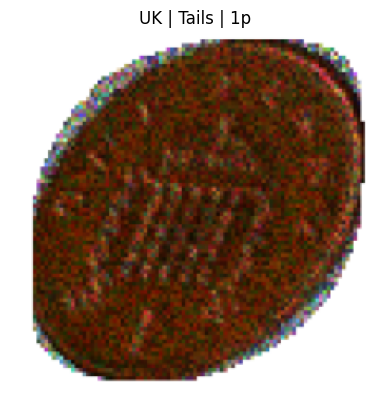

coins122_coin002.png → {'uk': 'UK', 'side': 'Tails', 'denomination': '5p'}


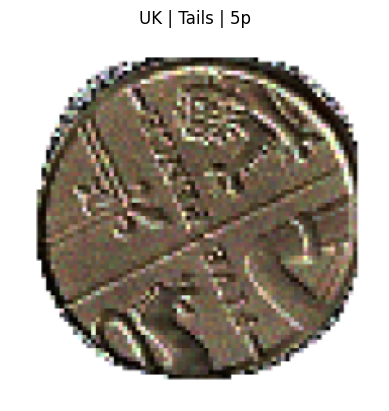

coins125_coin001.png → {'uk': 'UK', 'side': 'Tails', 'denomination': '1p'}


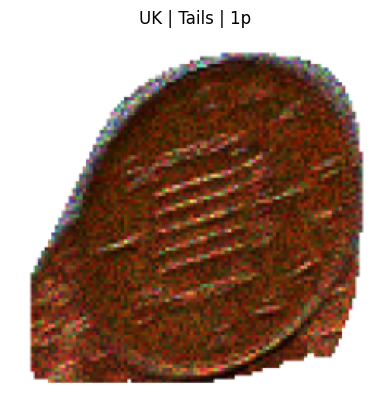

coins120_coin003.png → {'uk': 'UK', 'side': 'Tails', 'denomination': '2p'}


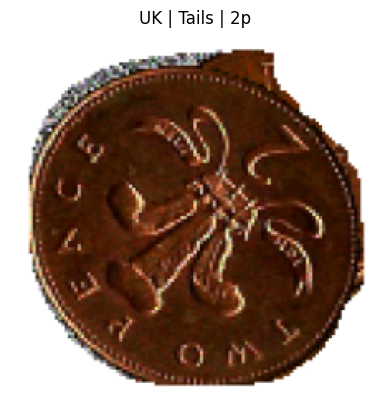

coins120_coin004.png → {'uk': 'UK', 'side': 'Tails', 'denomination': '1p'}


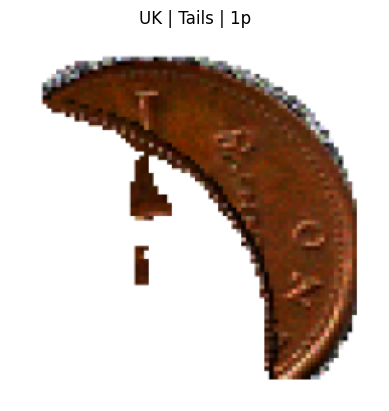

coins124_coin002.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '2p'}


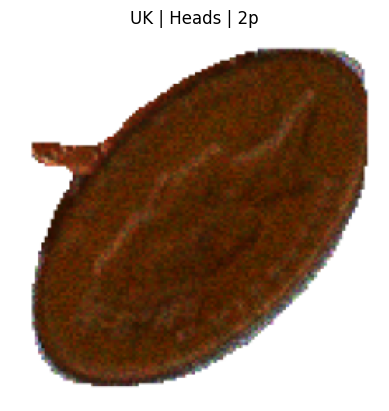

coins127_coin002.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '5p'}


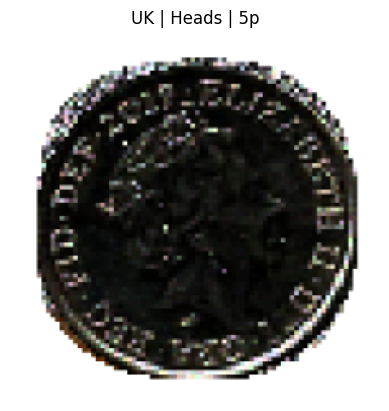

coins123_coin001.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '1p'}


coins125_coin002.png → {'uk': 'UK', 'side': 'Tails', 'denomination': '1p'}


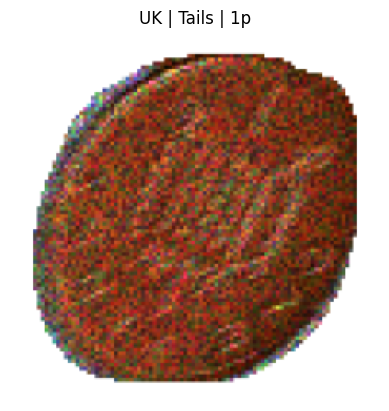

coins125_coin003.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '20p'}


coins117_coin001.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '10p'}


coins123_coin005.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '1p'}


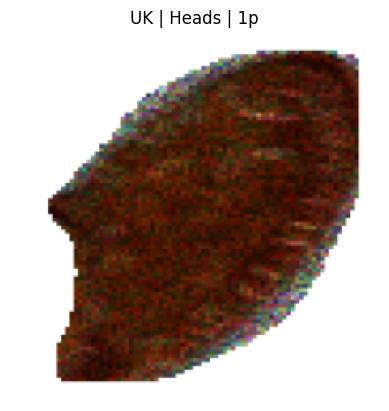

coins120_coin002.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '5p'}


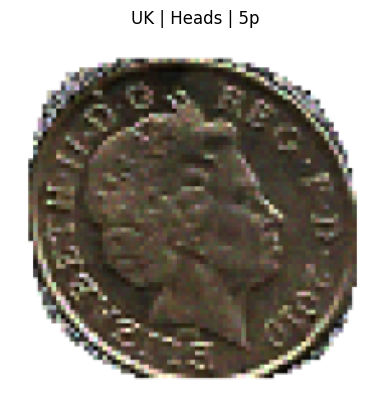

coins119_coin002.png → {'uk': 'UK', 'side': 'Heads', 'denomination': '5p'}


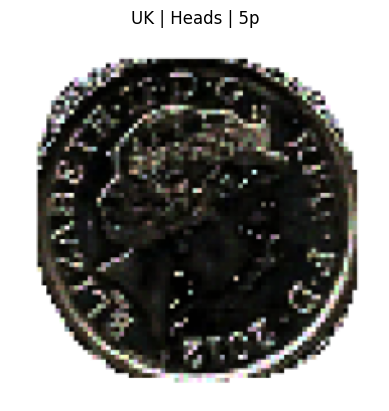

coins118_coin001.png → {'uk': 'Non-UK', 'side': 'Tails', 'denomination': 'Unknown'}


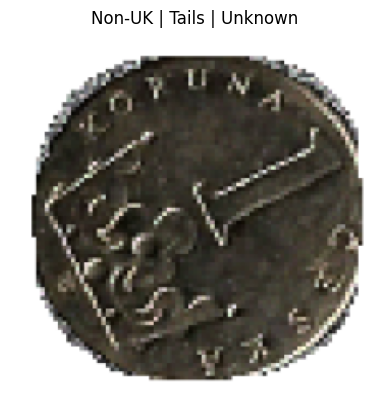

coins121_coin001.png → {'uk': 'Non-UK', 'side': 'Tails', 'denomination': 'Unknown'}


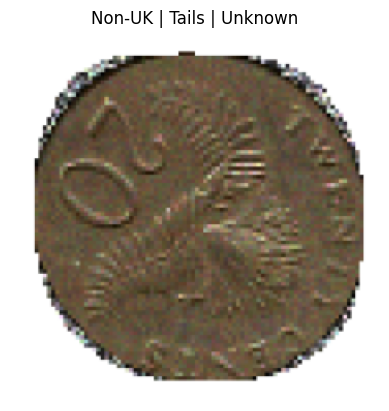

coins121_coin002.png → {'uk': 'Non-UK', 'side': 'Tails', 'denomination': 'Unknown'}


coins114_coin004.png → {'uk': 'Non-UK', 'side': 'Heads', 'denomination': 'Unknown'}


coins101_coin003.png → {'uk': 'Non-UK', 'side': 'Heads', 'denomination': 'Unknown'}


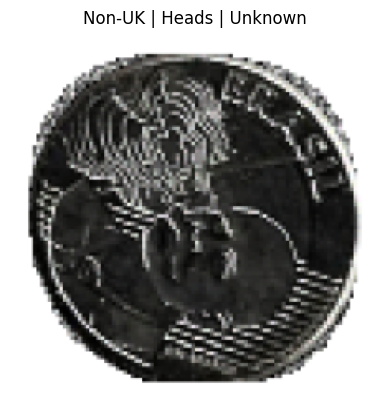

coins102_coin002.png → {'uk': 'Non-UK', 'side': 'Tails', 'denomination': 'Unknown'}


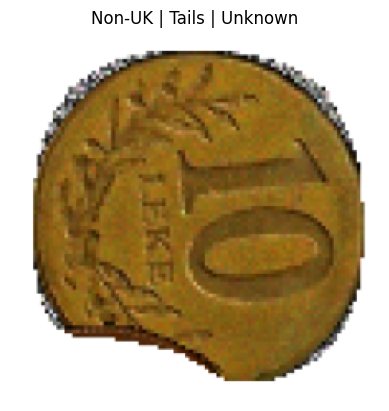

coins108_coin001.png → {'uk': 'Non-UK', 'side': 'Tails', 'denomination': 'Unknown'}


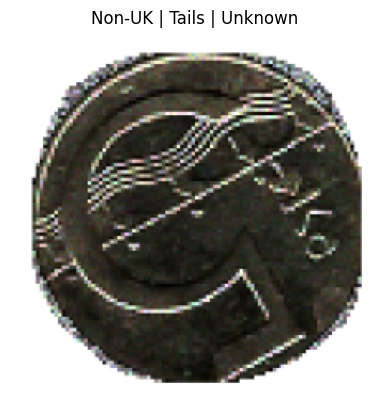

coins101_coin001.png → {'uk': 'Non-UK', 'side': 'Tails', 'denomination': 'Unknown'}


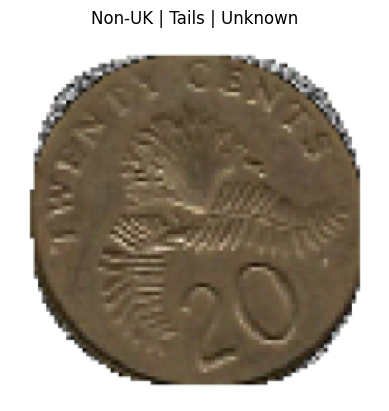

In [ ]:
# Directory containing unseen test images
unseen_dir = "/content/drive/MyDrive/Hexcel_Company_Project/unseen-test"
results = []

# Loop through each image and make predictions
for fname in os.listdir(unseen_dir):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue  # skip non-image files

    img_path = os.path.join(unseen_dir, fname)
    image = Image.open(img_path).convert('RGB')
    img_tensor = infer_transform(image).unsqueeze(0).to(device)


    with torch.no_grad():
        outputs = model(img_tensor)
        uk_pred = torch.argmax(outputs['uk'], dim=1).item()
        side_pred = torch.argmax(outputs['side'], dim=1).item()
        denom_pred = torch.argmax(outputs['denomination'], dim=1).item()

    # decode and store results
    decoded = decode_prediction(uk_pred, side_pred, denom_pred)
    print(f"{fname} → {decoded}")
    results.append({'filename': fname, **decoded})

    plt.imshow(image) # visuilze images predications
    plt.axis('off')
    plt.title(f"{decoded['uk']} | {decoded['side']} | {decoded['denomination']}")
    plt.show()


# Visualizing Model Attention with Grad-CAM

To understand what the model focuses on when predicting a coin’s denomination, Grad-CAM is used to generate visual attention maps. These highlight the regions in the image that influence the model’s decision.

This is especially useful for verifying whether the model is attending to relevant features, such as numbers, textures, or edges, rather than background noise. The visualization overlays the activation heatmap on top of the original coin image.



The implemntation of Grad-Cam refrences used:
- https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

- https://keras.io/examples/vision/grad_cam/

In [32]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [33]:
import torch
import torch.nn.functional as F
from torchvision import models
from torchcam.methods import GradCAM
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np


In [36]:

num_denom_classes = 5
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_denom_classes)


In [ ]:
cam_extractor = GradCAM(model, target_layer="features.6")  # efficientNet's last conv block


In [ ]:
# a sample image and label from the validation dataset
image, labels = val_df[0]
input_tensor = image.unsqueeze(0).to(device)

model.eval()
output = model(input_tensor)
task = 'denomination'
pred_class = output.argmax(dim=1).item()


In [ ]:
try:
    cam_list = cam_extractor(class_idx=[pred_class], scores=output)
    activation_map = cam_list[0]
except Exception as e:
    print(f"Grad-CAM extraction failed: {e}")
    activation_map = None


In [ ]:
if activation_map is not None:
    if activation_map.ndim == 3:
        activation_map = activation_map[0]

    # resize the activation map to match the image size
    activation_map_resized = F.interpolate(
        activation_map.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze().cpu().numpy()

    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5 + 0.5).clip(0, 1)  # Convert from

    # create heatmap and overlay
    colored_cam = cm.jet(activation_map_resized, alpha=0.5)[:, :, :3]
    overlay = (colored_cam * 255 + image_np * 255) / 2

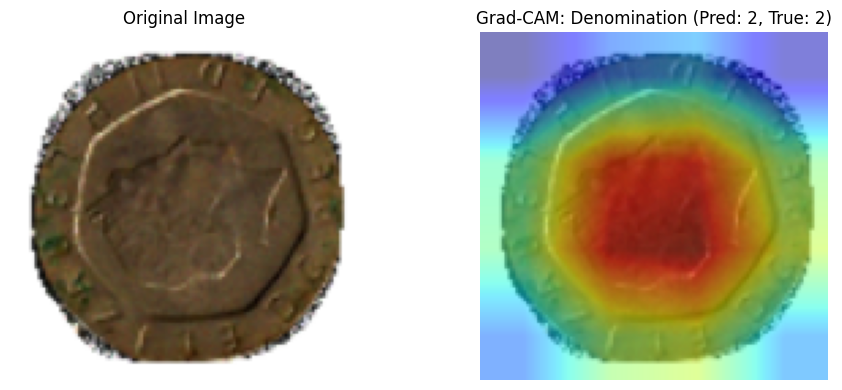

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay.astype(np.uint8))
plt.title(f"Grad-CAM: {task.capitalize()} (Pred: {pred_class}, True: {labels[task].item()})")
plt.axis("off")
plt.tight_layout()
plt.show()



From the plot image on the left shows the original input coin, while the image on the right displays a Grad-CAM heatmap overlay, visualizing where the model focused its attention during the denomination prediction.

In this case, the model correctly predicted the denomination as class 2, which matches the ground truth label. The Grad-CAM activation highlights the central region of the coin, where important visual features such as engraving patterns or texture details are typically found.

The strong red/yellow activation indicates that the model is relying on meaningful coin-specific features rather than background noise or irrelevant edges. This supports the interpretation that the model is making informed and interpretable decisions, especially useful for understanding  reliablity in coin classification tasks.